In [ ]:
%%capture
# Install 
!pip install git+https://github.com/cschlick/PhenixML.git
# clone for the data files
!git clone https://github.com/cschlick/PhenixML.git 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import sys
from contextlib import closing
from multiprocessing import Pool
sys.path.append("PhenixML")

from phenixml.fragments.fragments import MolContainer, Fragment
from phenixml.fragmentation.fragmenters import MoleculeFragmenter, BondFragmenter, AngleFragmenter
from phenixml.featurizers.fragments.fingerprints import MorganFeaturizer
from phenixml.labelers.fragment_labelers import BondFragmentLabeler, AngleFragmentLabeler

from phenixml.visualization.fragment_display import FragmentDisplay
from phenixml.visualization.plotting import plot_geom_eval
from phenixml.utils.torch_utils import to_np
display = FragmentDisplay()


from phenixml.featurizers.fragments.ani_featurizer import ANIFeaturizer

In [3]:
#get molecules
mol_dir = "/dev/shm/cschlick/geostd_passed/"
containers = MolContainer.from_folder(mol_dir)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16151/16151 [00:32<00:00, 497.76it/s]


In [9]:
%%time
# Fragment and featurize using multiprocessing

# define worker function
def worker(container):
  fragmenter = BondFragmenter(exclude_elements=["H"])
  fragments = fragmenter(container)
  try:
    features = ANIFeaturizer.from_fragments_midpoint(fragments)
    return (fragments,features)
  except:
    return None

# Run
work = containers
results = []
with closing(Pool(processes=64)) as pool:
  for result in tqdm.tqdm(pool.imap_unordered(worker, work), total=len(work)):
      results.append(result)
  pool.terminate()


# Collate results
fragments = []
features = []
for result in results:
  if result is not None:
    fragments+= result[0]
    features.append(result[1])
features = np.vstack(features)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16150/16150 [00:50<00:00, 321.44it/s]


CPU times: user 48.5 s, sys: 14.6 s, total: 1min 3s
Wall time: 54 s


In [11]:
%%time
# label the fragments
labeler = BondFragmentLabeler()
labels = labeler(fragments)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 396400/396400 [09:06<00:00, 725.04it/s]


CPU times: user 14min 2s, sys: 2min 46s, total: 16min 48s
Wall time: 9min 9s


In [12]:
# train/test split
from sklearn.model_selection import train_test_split
inds = np.arange(len(fragments))
train,test = train_test_split(inds,test_size=0.2)
feat_train, feat_test = features[train], features[test]
labels_train, labels_test = labels[train], labels[test]
frags_train = [fragments[i] for i in train]
frags_test = [fragments[i] for i in test]

## Plot aev

In [ ]:
def plot_aev(self,site_index=0,plot_region="all",plot_style="bar"):


    # set some params that will need to be taken from the aev object

    n_radial_components = len(self.radial_elements)
    n_angular_components = len(self.angular_elements)

    n_rs_rad = len(self.rs_rad)
    n_rs_ang = len(self.rs_ang)
    n_ts = len(self.ts)


    radial_symbols = self.radial_elements
    angular_symbols = [j+"."+k for j,k in self.angular_elements]

    full_flat = np.concatenate([self.gr[site_index],self.ga[site_index]])

    radial_length = n_radial_components*n_rs_rad
    angular_length = n_angular_components*n_rs_ang*n_ts
    full_length = radial_length+angular_length


    radial_end = (n_radial_components*n_rs_rad)
    radial_spacing = n_rs_rad
    radial_locs = np.linspace(0,radial_end-radial_spacing,n_radial_components)-0.5

    angular_locs = np.linspace(radial_end,full_length,n_angular_components+1)-0.5
    angular_spacing = n_rs_ang*n_ts
    line_locs = np.concatenate([radial_locs,angular_locs])
    label_locs = np.concatenate([radial_locs+(radial_spacing/2),angular_locs[:-1]+(angular_spacing/2)])
    labels = radial_symbols+angular_symbols

    xlabel_fontsize=11
    figure_size_inches = (16,6)
    color="#5799c6"
    width_ratio = 3
    line_y_max = 0.05
    fig, ax = plt.subplots(1,1,gridspec_kw={'width_ratios': [width_ratio]})


    if plot_style=="bar":
      ax.bar(np.arange(full_length),full_flat,color=color)
    elif plot_style=="line":
      ax.plot(np.arange(full_length),full_flat,color=color)

    ret1= ax.set_xticks(label_locs)
    ret2 = ax.set_xticklabels(labels,fontsize=xlabel_fontsize) 
    for loc in line_locs:
      ax.axvline(x=loc,ymax=line_y_max,color="black")
    ax.set_ylabel("EV Output")
    ax.axvline(x=line_locs[0],ymax=0.1,color="black")
    ax.axvline(x=radial_end-0.5,ymax=0.1,color="black")
    ax.axvline(x=line_locs[-1],ymax=0.1,color="black")
    fig.set_size_inches(figure_size_inches)

    if plot_region=="radial":
      ax.set_xlim(0,radial_length)
    elif plot_region=="angular":
      ax.set_xlim(radial_length-1,full_length)
    return ax

## kNN

In [14]:
%%time
from phenixml.models.nn_fragments import FragmentKNN
# Build the pynndescent index
knn = FragmentKNN(frags_train,feat_train)

CPU times: user 46min 39s, sys: 2min 28s, total: 49min 8s
Wall time: 3min 33s


In [15]:
# choose a single query to illustrate kNN search
query_idx = 100
query_frag = frags_test[query_idx]
query_feature = feat_test[query_idx]
query_label = labels_test[query_idx]

nbrs,inds = knn.query(query_feature,k=20, return_ind=True)
nbr_labels = labels_train[inds]

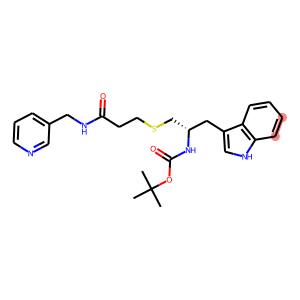

In [16]:
display(query_frag,hideHs=True,size=(300,300))

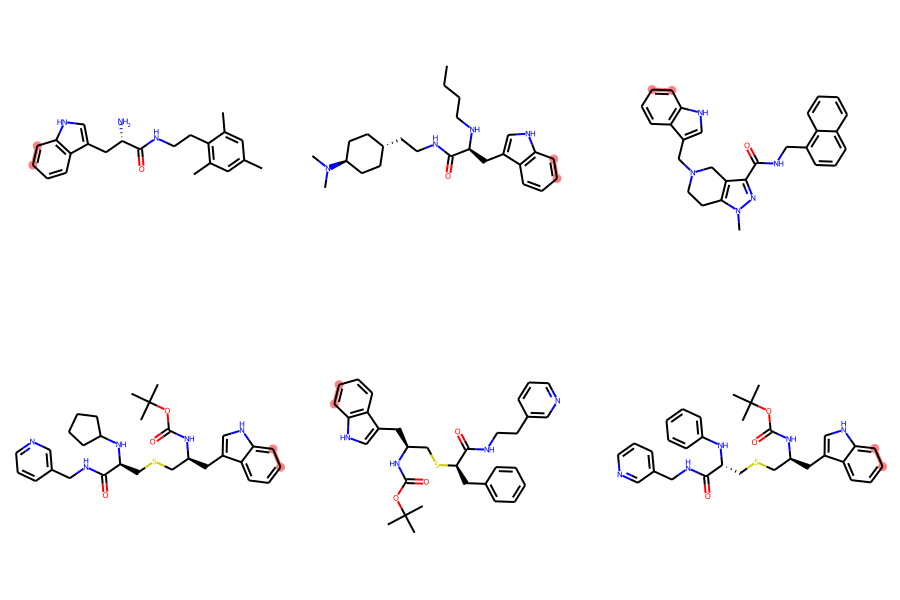

In [17]:
display(nbrs)

In [18]:
# kNN Regression
# Query the knn for the whole test set
nbrs,inds = knn.query(feat_test,k=20, return_ind=True)
nbr_labels = labels_train[inds]

In [20]:
nbr_mean_label = nbr_labels.mean(axis=1)

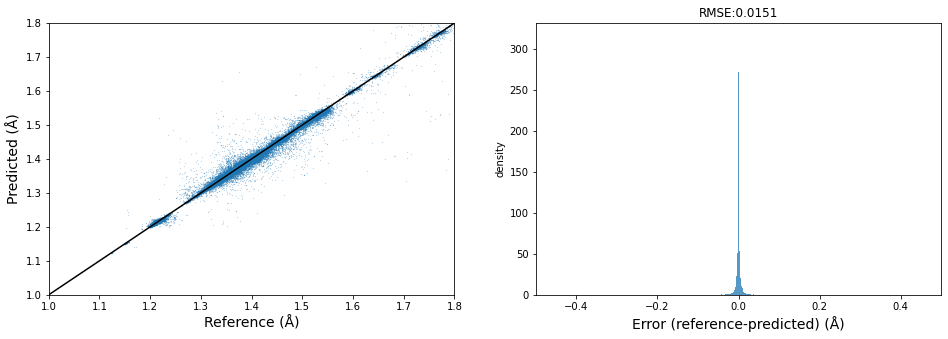

In [21]:
plot_geom_eval(labels_test,nbr_mean_label,mode="bond")

In [24]:
len(mol_containers)

15593

In [25]:
# evaluate
from collections import defaultdict
mol_containers = defaultdict(list)

labels_test_ref = labels_test
labels_test_pred = nbr_mean_label

for i,fragment in enumerate(frags_test):
  
  ref,pred = labels_test_ref[i], labels_test_pred[i]
  error = np.abs(ref-pred)
  mol_containers[fragment.mol_container].append(error)
  
worst = np.array([np.max(value) for key,value in mol_containers.items()])
cutoff = 0.1
n_ok = (worst<=cutoff).sum()
n_bad = (worst>cutoff).sum()
print("Number of mols in test set:",len(mol_containers))
print("Mols better than cutoff:",n_ok)
print("Mols worse than cutoff:",n_bad)

Number of mols in test set: 15593
Mols better than cutoff: 15417
Mols worse than cutoff: 176


## MLP Regression

In [30]:
import torch
from phenixml.models.feature_regression import FeatureModel

In [31]:
model = FeatureModel(feat_train.shape[1],256,1,n_hid_layers=1)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()

In [32]:
# set up tensors
feat_train_t = torch.tensor(feat_train,dtype=torch.get_default_dtype())
feat_test_t = torch.tensor(feat_test,dtype=torch.get_default_dtype())
labels_train_t = torch.tensor(labels_train,dtype=torch.get_default_dtype())

In [35]:
# Split training data into batches

def make_batches(lst, n=100000):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
feature_batches = make_batches(feat_train_t)
label_batches = make_batches(labels_train_t)
batches = list(zip(feature_batches,label_batches))
print("N batches:",len(batches))

N batches: 4


In [ ]:
# train
n_epoch=500
gpuid = None # set to 0,1, etc to specify which gpu (if any)

if gpuid is not None:
  model = model.to("cuda:"+str(gpuid))

epoch_losses = []
for epoch in tqdm.tqdm(range(n_epoch)):
  batch_losses = []
  for feat,label in batches:
    if gpuid is not None:
      feat = feat.to("cuda:"+str(gpuid))
      label = label.to("cuda:"+str(gpuid))
    pred = model(feat)[:,0]
    loss = metric(pred,label)
    opt.zero_grad()
    loss.backward()
    opt.step()
    batch_losses.append(loss.item())
  epoch_losses.append(np.mean(batch_losses))
  
  

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 447/500 [23:11<02:49,  3.19s/it]

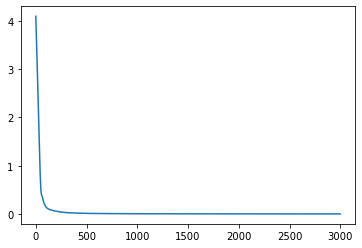

In [20]:
plt.plot(epoch_losses)

In [21]:
if gpuid is not None:
  model = model.to("cpu")
pred = model(feat_test_t)

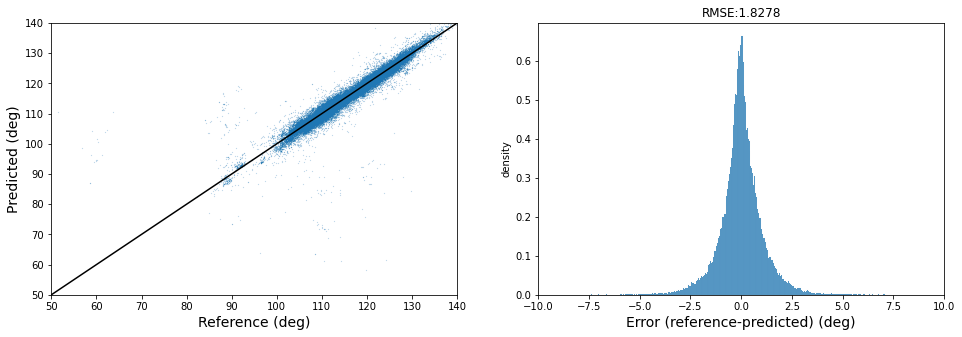

In [22]:
plot_geom_eval(np.degrees(labels_test),np.degrees(to_np(pred)),mode="angle")

In [ ]:
# evaluate
from collections import defaultdict
mol_containers = defaultdict(list)

labels_test_ref = labels_test
labels_test_pred = nbr_mean_label

for i,fragment in enumerate(frags_test):
  
  ref,pred = labels_test_ref[i], labels_test_pred[i]
  error = np.abs(ref-pred)
  mol_containers[fragment.mol_container].append(error)
  
worst = np.array([np.max(value) for key,value in mol_containers.items()])
cutoff = 10
n_ok = (worst<=cutoff).sum()
n_bad = (worst>cutoff).sum()
print("Number of mols in test set:",len(mol_containers))
print("Mols better than cutoff:",n_ok)
print("Mols worse than cutoff:",n_bad)